#### Import libraries:

In [16]:
import sys
sys.path.append('../src')
from PorousMediaLab import PorousMediaLab
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Setting up the properties of time-space and create the domain:

In [17]:
t = 27 / 365
dx = 0.2
L = 40
x = np.linspace(0, L, L / dx + 1)
phi = ( 0.98 - 0.7 ) * np.exp( -x / 20 ) + 0.7
dt = 1e-5
ftc = PorousMediaLab(L, dx, t, dt, phi)

#### To make things interesting lets create not simple inital conditions for iron:

In [18]:
x = np.linspace(0, L, L / dx + 1)
Fe3_init = np.zeros(x.size)
Fe3_init[x > 5] = 75
Fe3_init[x > 15] = 0
Fe3_init[x > 25] = 75
Fe3_init[x > 35] = 0

#### Adding species with names, diffusion coefficients, initial concentrations and boundary top and bottom conditions:

In [19]:
ftc.add_species(is_solute=True, element='O2', D=368, init_C=0, bc_top=0.231, bc_top_type='dirichlet', bc_bot=0, bc_bot_type='flux')
ftc.add_species(is_solute=True, element='CO2', D=320, init_C=0, bc_top=0, bc_top_type='flux', bc_bot=0, bc_bot_type='flux')
ftc.add_species(is_solute=True, element='Fe2', D=127, init_C=0, bc_top=0, bc_top_type='flux', bc_bot=0, bc_bot_type='flux')
ftc.add_solid_species('OM', 15)
ftc.add_solid_species('FeOH3', Fe3_init)
C_init=1e-7
ftc.add_species(is_solute=True, element='H2CO3', D=320, init_C=C_init, bc_top=0., bc_top_type='flux', bc_bot=0, bc_bot_type='flux')
ftc.add_species(is_solute=True, element='HCO3', D=320, init_C=C_init, bc_top=0., bc_top_type='flux', bc_bot=0, bc_bot_type='flux')
ftc.add_species(is_solute=True, element='CO3', D=320, init_C=C_init, bc_top=0., bc_top_type='flux', bc_bot=0, bc_bot_type='flux')
# ftc.add_acid_base_equilibrium(species=['H2CO3', 'HCO3', 'CO3'], pKa=[3.6, 10.32])

#### Specify the constants used in the rates:

In [20]:
ftc.constants['k_OM'] = 1
ftc.constants['Km_O2'] = 20e-3
ftc.constants['Km_FeOH3'] = 10
ftc.constants['k8'] = 1.4e+5
ftc.constants['Q10'] = 4  ### added
ftc.constants['CF'] = (1-phi)/phi  ### conversion factor

### Simulate Temperature with thermal diffusivity coefficient 281000 and init temperature 5C:

In [21]:
ftc.add_temperature(D=281000, init_temperature=5)

#### Add Q10 factor:

In [22]:
ftc.rates['R1'] = 'Q10**((Temperature-5)/10) * k_OM * OM * O2 / (Km_O2 + O2)'
ftc.rates['R2'] = 'Q10**((Temperature-5)/10) * k_OM * OM * FeOH3 / (Km_FeOH3 + FeOH3) * Km_O2 / (Km_O2 + O2)'
ftc.rates['R8'] = 'k8 * O2 * Fe2'

#### ODEs for specific species:

In [23]:
ftc.dcdt['OM'] = '-R1-R2'
ftc.dcdt['O2'] = '-R1-R8'
ftc.dcdt['FeOH3'] = '-4*R2+R8*1/CF'
ftc.dcdt['Fe2'] = '-R8+4*R2*CF'
ftc.dcdt['HCO3'] = 'R1*CF+R2'

#### Because we are changing the boundary conditions for temperature and Oxygen (when T < 0 => no oxygen at the top), then we need to have a time loop:

In [24]:
for i in range(1, len(ftc.time)):
    day_of_bi_week = (ftc.time[i]*365) % 14

    if day_of_bi_week < 7:
        ftc.Temperature.bc_top = 5  + 5 * np.sin(np.pi * 2 * ftc.time[i] * 365)
    else:
        ftc.Temperature.bc_top = -10  + 5 * np.sin(np.pi * 2 * ftc.time[i] * 365)
        
    # when T < 0 => 0 flux of oxygen and CO2 at the top:
    if ftc.Temperature.bc_top < 0:
        ftc.change_boundary_conditions('O2', i, bc_top=0, bc_top_type='flux')
        ftc.change_boundary_conditions('CO2', i, bc_top=0, bc_top_type='flux')
    else:
        ftc.change_boundary_conditions('O2', i, bc_top=0.231, bc_top_type='constant')
        ftc.change_boundary_conditions('CO2', i, bc_top=0, bc_top_type='constant')
        
    # Integrate one timestep:
    ftc.integrate_one_timestep(i)

### What we did with temperature

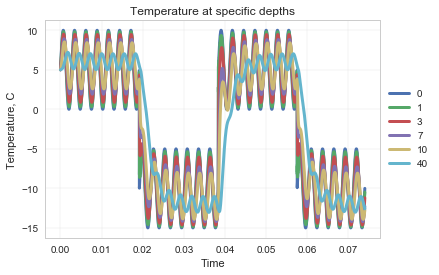

In [25]:
ftc.plot_depths("Temperature",[0,1,3,7,10,40])

### Concentrations of different species during the whole period of simulation:

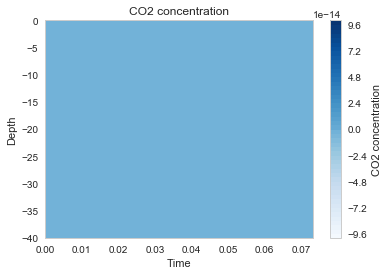

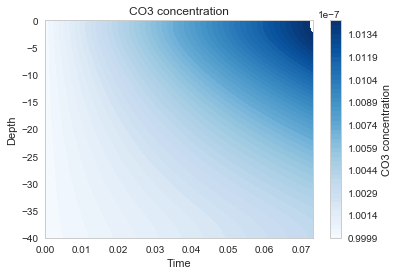

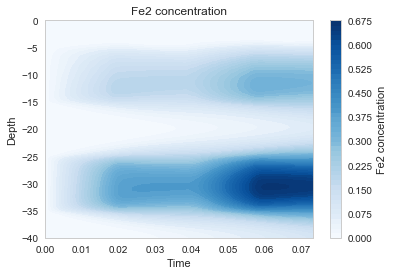

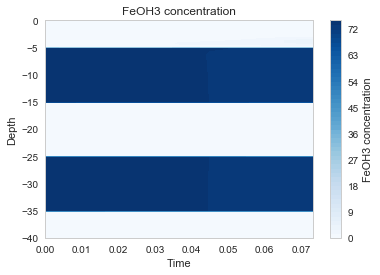

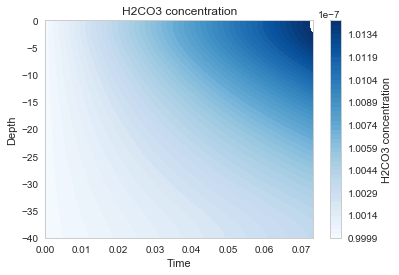

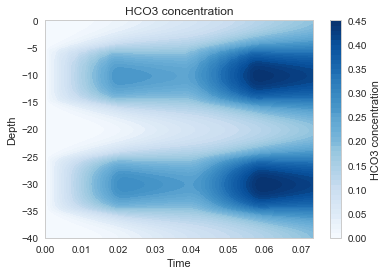

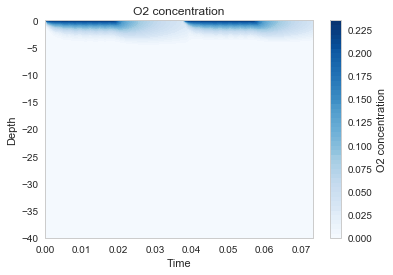

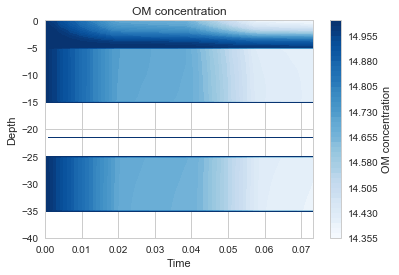

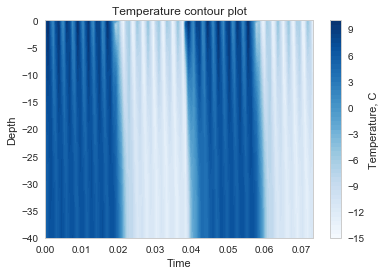

In [26]:
ftc.plot_contourplots()

### The rates of consumption and production of species:

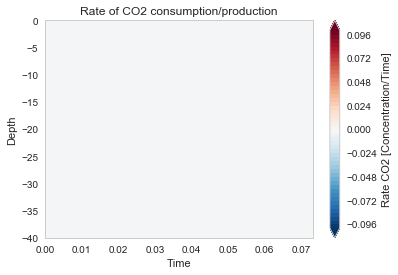

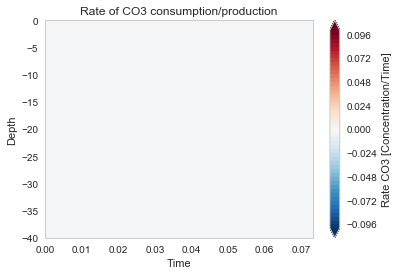

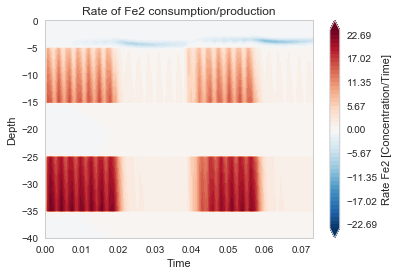

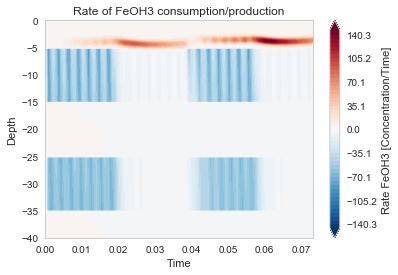

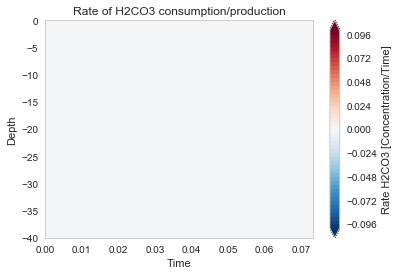

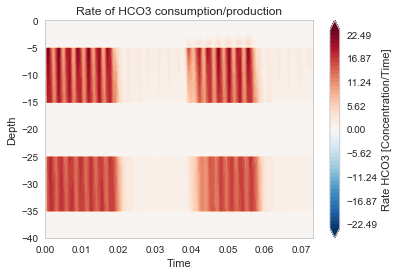

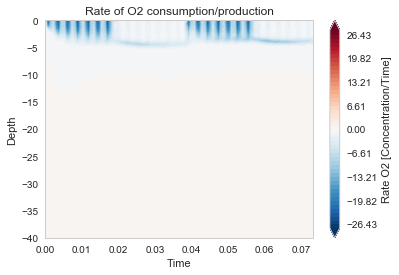

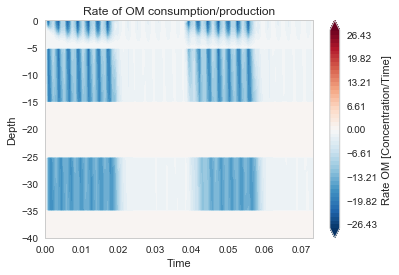

In [27]:
ftc.plot_contourplots_of_rates()

### Profiles at the end of the simulation

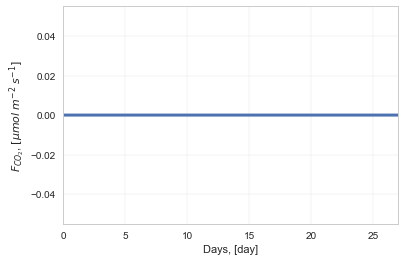

In [28]:
Fx = ftc.estimate_flux_at_top('CO2')
ftc.custom_plot(ftc.time*365, 10**4/(60*60*24)*Fx,x_lbl='Days, [day]' , y_lbl='$F_{CO_2}$, $[\mu mol$ $m^{-2}$ $s^{-1}]$')